In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import napari
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(2000)

save_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2025_04_14 Stas\figures")

Index(['Unnamed: 0', 'ID', 'VISIBILITY', 'RADIUS', 'QUALITY', 'POSITION_T',
       'POSITION_Z', 'POSITION_Y', 'FRAME', 'POSITION_X', 'track_id',
       'position_cluster', 'distance_from_edge', 'tracklet_id', 'parent_id',
       'daughter_id'],
      dtype='object')


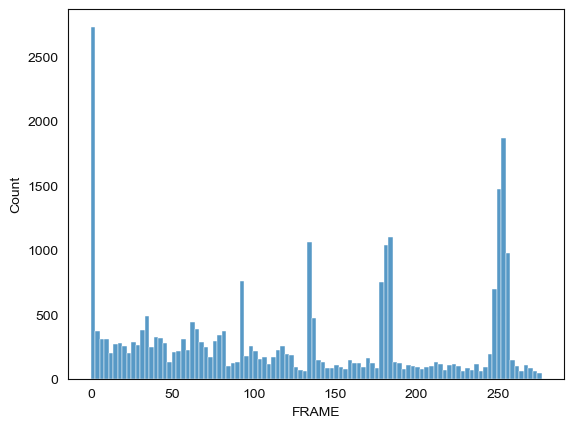

In [26]:
sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19a_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19b_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

source = r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19b_trk\hybrid\spots.csv"
source = sources[5]

df = pd.read_csv(source)
print(df.columns)

sns.histplot(df.groupby("tracklet_id")["FRAME"].min(), bins=100)

plt.show()

viewer = napari.Viewer()

um_per_px = 0.525
df = df[df["FRAME"] == df["FRAME"].max()]
df["x"] = df["POSITION_X"] * um_per_px
df["z"] = df["POSITION_Z"] * um_per_px
df["y"] = df["POSITION_Y"] * um_per_px
pos = np.array(df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep
transformed_data = pca.fit_transform(pos)
viewer.add_points(transformed_data[df["FRAME"] == df["FRAME"].max()], size=5, shading="spherical")
napari.run()

In [29]:
sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19a_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_19b_trk\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

all_cycle_starts = [
    np.array([0, 25, 50, 100, 200, 280]),
    np.array([0, 50, 80, 125, 200, 280]),
    np.array([0, 20, 60, 100, 180, 280]),
    np.array([0, 30, 60, 110, 160, 280]),
    np.array([0, 40, 75, 120, 165, 280]),
    np.array([0, 80, 110, 160, 210, 280])
]

time_scales = [
    20,
    20,
    20,
    22,
    20,
    22
]

anterior = [
    240,
    240,
    225,
    240,
    240,
    227,
]

posterior = [
    -222,
    -224,
    -233,
    -212,
    -220,
    -212,
]

trk = [
    True,
    True,
    True,
    False,
    False,
    False,
]

In [160]:
dfs = []
best_dfs = []
um_per_px = 0.525

for i, source in enumerate(sources):
    df = pd.read_csv(source)

    df["x"] = df["POSITION_X"] * um_per_px
    df["z"] = df["POSITION_Z"] * um_per_px
    df["y"] = df["POSITION_Y"] * um_per_px
    df_last = df[df["FRAME"] == df["FRAME"].max()]
    pos = np.array(df_last[["x", "y", "z"]])
    pca = PCA(n_components=3)
    pca.fit(pos)
    
    transformed_data = pca.transform(np.array(df[["x", "y", "z"]]))
    
    a = anterior[i]
    p = posterior[i]
    
    df["AP_raw"] = transformed_data[:, 0]
    df["AP"] = (df["AP_raw"] - a) / (p - a)
    df["AP_um"] = df["AP"] * np.abs(a - p)
    df["AP_um_centered"] = (df["AP"]-0.5) * np.abs(a - p)
    df["um_from_anterior"] = np.abs(df["AP_raw"] - a)
    df["um_from_posterior"] = np.abs(df["AP_raw"] - p)
    df["distance_to_pole"] = np.min(np.stack([df["um_from_anterior"], df["um_from_posterior"]], axis=-1), axis=-1)
    
    df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    df["time"] = df["FRAME"] * time_scales[i] / 60
    df["tracklet_start_time"] = df["tracklet_id"].map(df.groupby("tracklet_id")["time"].min())
    
    df["trk"] = trk[i]
    
    cycle_starts = all_cycle_starts[i]
    t_cycle = df.groupby("tracklet_id")["FRAME"].min().apply(lambda time: np.argmax(cycle_starts > time))
    df["cycle"] = df["tracklet_id"].map(t_cycle)
        
    best_df = df[df["track_id"] > 0].copy()
    n_tracklets = best_df["track_id"].map(best_df.groupby("track_id")["tracklet_id"].nunique())
    best_df = best_df[n_tracklets > 1]
    
    t = best_df.groupby("tracklet_id")
    ts = {}
    ts["time_start"] = t["time"].min()
    ts["time_end"] = t["time"].max()
    ts["length"] = t["time"].max() - t["time"].min()
    ts["cycle"] = t["cycle"].first()
    
    tracklets = pd.DataFrame(ts)
    
    cycle_avg_length = tracklets.groupby("cycle")["length"].median()
    
    tracklets["cycle_avg"] = tracklets["cycle"].map(cycle_avg_length)
    tracklets["good"] = np.abs(tracklets["length"] - tracklets["cycle_avg"]) < 6
    
    best_df = best_df[best_df["tracklet_id"].map(tracklets["good"])].copy()
    
    nc10 = all_cycle_starts[i][1]
    frame = best_df[best_df["FRAME"] == nc10]
    nc10_time = frame["tracklet_start_time"].median()
    df["time_since_nc10"] = df["time"] - nc10_time
    best_df["time_since_nc10"] = best_df["time"] - nc10_time
    
    dfs.append(df)
    best_dfs.append(best_df)

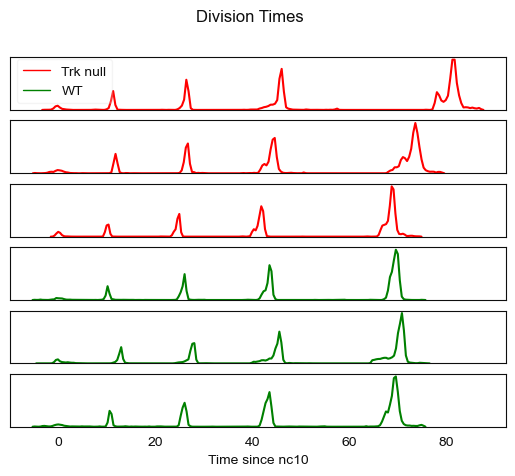

In [88]:
fig, axes = plt.subplots(6, 1, sharex=True)

colors = ["green", "red"]

for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    sns.kdeplot(x=df[df["time_since_nc10"]>-5].groupby("tracklet_id")["time_since_nc10"].min(), color=color, ax=ax,
                bw_adjust=0.05)
    
    # t = df[df["time_since_nc10"]>-5].groupby("tracklet_id")
    # sns.kdeplot(x=t["time_since_nc10"].min(), hue=t["cycle"].first(), ax=ax,
    #             bw_adjust=0.05)
    # 
    ax.set_ylabel("")
    ax.set_yticks([])
    # ax.vlines([0], 0, 0.25, color="k")
    
plt.xlabel("Time since nc10")
plt.suptitle("Division Times")

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color=colors[1], lw=1),
                Line2D([0], [0], color=colors[0], lw=1)]

axes[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / "division_times.png", dpi=300)

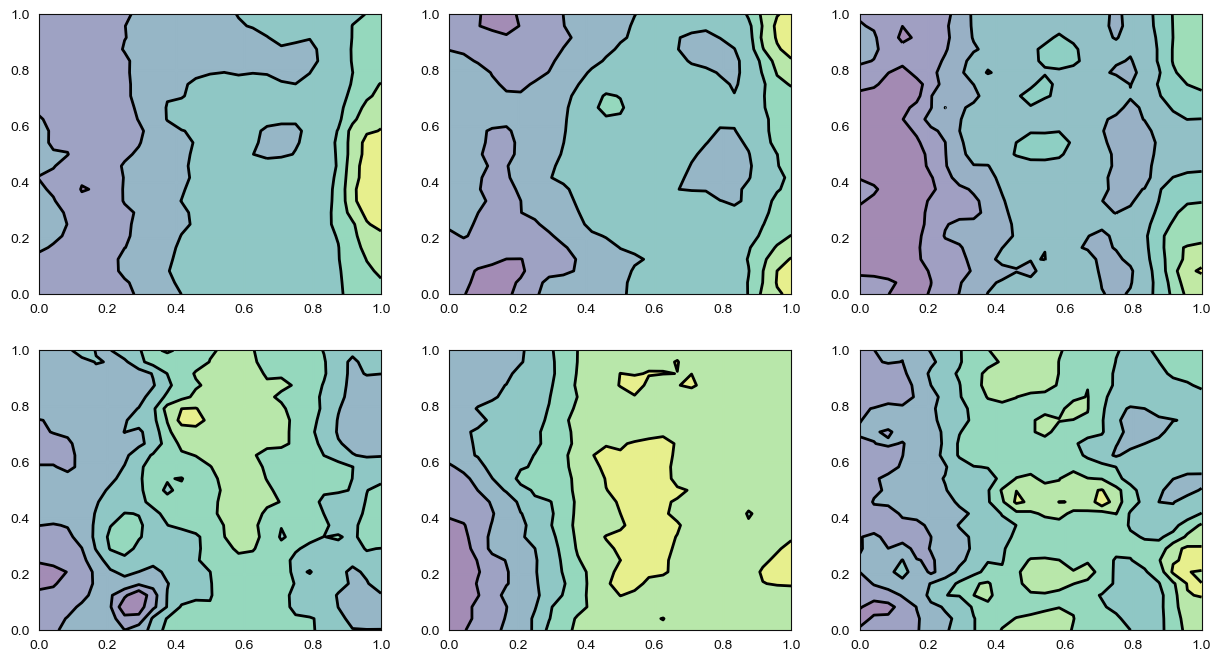

In [123]:
from sklearn.neighbors import NearestNeighbors

def get_contour(x, y, z, n=50):
    
    x = (x.copy()  - x.min())/ (x.max() - x.min())
    y = (y.copy()  - y.min())/ (y.max() - y.min())
    
    tester = NearestNeighbors()
    tester.fit(np.array([x, y]).T)
    
    
    x_bins = np.linspace(x.min(), x.max(), n)
    y_bins = np.linspace(y.min(), y.max(), n)
    X, Y = np.meshgrid(x_bins, y_bins)
    
    Z = np.zeros_like(X)
    for i, x_bin in enumerate(x_bins):
        for j, y_bin in enumerate(y_bins):
            _, indices = tester.kneighbors([[x_bin, y_bin]], 25)
            Z[j, i] = np.mean([z[idx] for idx in indices[0]])

    return X, Y, Z

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cycle = 4


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = t["AP"].last()
    y = t["theta"].last()
    z = np.array(t["time"].max())
    z = z - np.mean(z)
    
    X, Y, Z = get_contour(x, y, z, n=25)
    
    plt.sca(ax)
    plt.contourf(X, Y, Z, levels=6, cmap="viridis", alpha=0.5)
    plt.contour(X, Y, Z, levels=6, colors="k", linewidths=2, linestyles="solid")
    
plt.show()


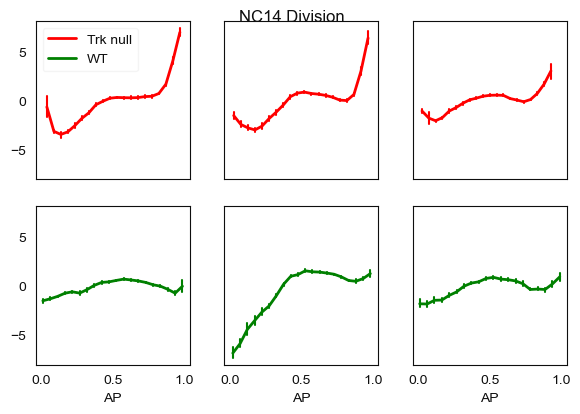

In [144]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), sharex=True, sharey=True)
cycle = 4

plt.tight_layout()


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = pd.cut(t["AP"].last(), 20)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max())
    
    y = y - np.mean(y)
    
    sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", color=color, lw=2)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_line.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()

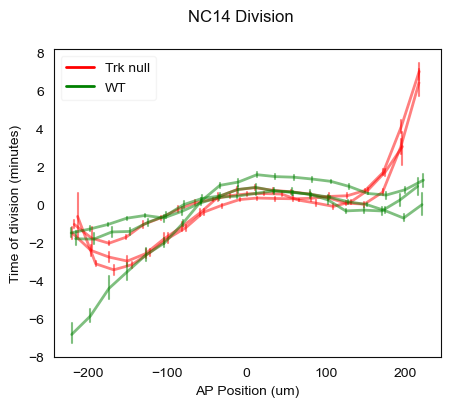

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cycle = 4

# plt.tight_layout()

for i, df in enumerate(best_dfs):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = pd.cut(t["AP_um_centered"].last(), 20)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max())
    
    y = y - np.mean(y)
    
    sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", color=color, lw=2, alpha=0.5)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

ax.legend(custom_lines, ["Trk null", "WT"])
ax.set_ylabel("Time of division (minutes)")
ax.set_xlabel("AP Position (um)")

plt.suptitle(f"NC{cycle + 10} Division")
plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_single_line.png", dpi=300)

plt.show()

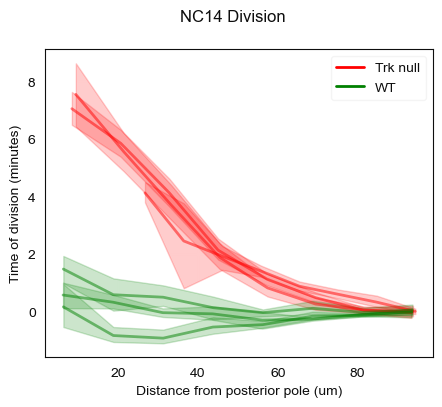

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cycle = 4

# plt.tight_layout()

for i, df in enumerate(best_dfs):
    
    color = colors[trk[i]]
        
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    tdf = {}
    tdf["ap_last"] = t["AP"].last()
    tdf["um_last"] = t["um_from_posterior"].last()
    tdf["end"] = t["time"].max()
    
    t = pd.DataFrame(tdf)
    
    t = t[t["um_last"] < 100]
    
    x = pd.cut(t["um_last"], 8)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    
    last = t[t["um_last"] > 90]["end"].mean()
    
    y = np.array(t["end"])
    
    y = y - last
    
    sns.lineplot(x=x, y=y, ax=ax, errorbar=("ci", 95), err_style="band", color=color, lw=2, alpha=0.5)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

ax.legend(custom_lines, ["Trk null", "WT"])
ax.set_ylabel("Time of division (minutes)")
ax.set_xlabel("Distance from posterior pole (um)")

plt.suptitle(f"NC{cycle + 10} Division")
plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_from_p.png", dpi=300)

plt.show()

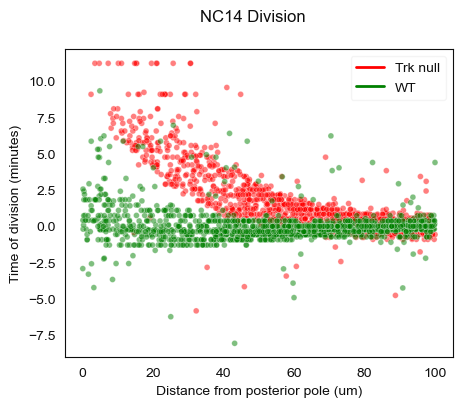

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cycle = 4

# plt.tight_layout()

for i, df in enumerate(best_dfs):
    
    color = colors[trk[i]]
        
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    tdf = {}
    tdf["ap_last"] = t["AP"].last()
    tdf["um_last"] = t["um_from_posterior"].last()
    tdf["end"] = t["time"].max()
    
    t = pd.DataFrame(tdf)
    
    t = t[t["um_last"] < 100]
    
    x = t["um_last"]
    # x = pd.cut(t["um_last"], 15)
    # x = x.apply(lambda v: (v.left + v.right) / 2)
    
    last = t[t["um_last"] > 90]["end"].mean()
    
    y = np.array(t["end"])
    
    y = y - last
    
    sns.scatterplot(x=x, y=y, ax=ax, alpha=0.5, size=2, color=color)
    

custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

ax.legend(custom_lines, ["Trk null", "WT"])
ax.set_ylabel("Time of division (minutes)")
ax.set_xlabel("Distance from posterior pole (um)")

plt.suptitle(f"NC{cycle + 10} Division")
plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_from_p_scatter.png", dpi=300)

plt.show()

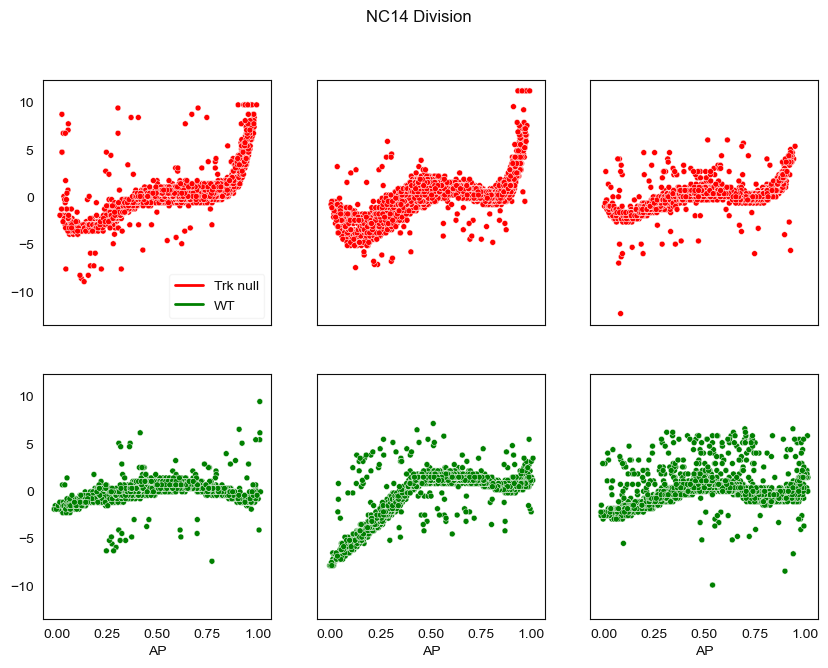

In [140]:
fig, axes = plt.subplots(2, 3, figsize=(10,  7), sharex=True, sharey=True)
cycle = 4


for i, (df, ax) in enumerate(zip(best_dfs, axes.flatten())):
    
    color = colors[trk[i]]
    
    t = df[df["cycle"] == cycle].groupby("tracklet_id")
    
    x = t["AP"].last()
    # x = pd.cut(t["AP"].last(), 20)
    # x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max())
    
    y = y - np.mean(y)
    
    sns.scatterplot(x=x, y=y, ax=ax, color=color, size=1, legend=False)


custom_lines = [Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_scatter.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()